<h1 style="text-align: center"> Assignment #3 </h1>


<h4 style="text-align: center"> Kevin McManus </h4>
<h4 style="text-align: center"> Student ID: 109702479</h4>

## Data Class

Copied from the `Chapter3.ipynb` notebook, with the following modifcations:

* `GetTableData` method now calculates attribute `ny` correctly
* Implemented `Slice` method which slices the `x` and `y` data arrays by an arbitrary `slice` object
* Changed default linestyle in `MyHistogram`. The previous default, `steps` appears not to work in newer versions of `matplotlib`

In [1]:
#Chapter 3
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.interpolate import UnivariateSpline
import scipy.ndimage
from scipy import signal
from astropy.io import fits

class MyData:
    def __init__(self,filename='NoFile'):
        self.filename = filename
        self.ndim = 0 
        self.x = []
        self.nx = 0
        self.y = []
        self.ny = 0
        self.z = []
        self.nz = 0
        self.array = []
        self.header = []
        self.nxa = 0
        self.nya = 0
        
    def xline(self,xmin,xmax,nx):
        self.nx = nx
        self.ndim = 1
        self.x = np.linspace(xmin,xmax,nx)

    def yline(self,a,b):
        if(self.ndim == 1):
            self.ny = self.nx
            self.y = a + b*self.x
        else:
            print("x value not one dimensional")

    def plotxy(self):
        plt.cla()
        plt.title(self.filename)
        plt.plot(self.x,self.y)
        plt.show()

    def plotpoints(self):
        plt.cla()
        plt.title(self.filename)
        #plt.plot(self.x,self.y)
        plt.scatter(self.x, self.y, s=2, marker='o', c='black')
        plt.show()

    def GetFits(self, filename):
        self.filename = filename
        hdul = fits.open(filename)
        self.array = fits.getdata(filename)
        self.header = hdul[0].header
        sh = np.shape(self.array)
        self.nxa = sh[0]
        self.nya = sh[1]
        self.ndim = 2
            
    def GetTableData(self, filename):
        self.filename = filename
        data_array=np.genfromtxt(filename)
        s = data_array.shape
        if len(s) == 1 :
            self.x= data_array
            self.nx = s[0]
        if len(s) == 2 :
            self.x = data_array[:, 0]
            self.y = data_array[:, 1]
            self.nx = s[0]
            self.ny = s[0] #one y value for each x value

    def WriteTableData(self,filename='test.txt'):
        f = open(filename,"w")
        if self.ny == 0:
            for i in range(0,self.nx):
                f.write('%8.4f\n' % self.x[i] )
        else:
            for i in range(0,self.nx):
                f.write('%8.4f  %8.4f\n' % (self.x[i],self.y[i]))
        f.close()

    def Quicklook(self):
        if (self.nx == 0):
            print("Whoops! No Data")
            return
        plt.cla()
        if self.ny == 0:
            plt.plot(self.x, c='black')
        else:
            plt.scatter(self.x, self.y, s=2, marker='o', c='black')
        plt.show()
        print("length of x list is ",len(self.x), "items")
        
    def ReadInteger16(self,filename,nxa=256,nya=256):
        self.filename = filename
        data = np.fromfile('m33.dat', dtype='i2')
        self.array = np.reshape(np.array(data),(nxa,nya))
        self.ndim = 2
        self.nxa = nxa
        self.nya = nya
        
    def WriteFloat64(self,filename="test.dat"):
        self.filename = filename
        f= open(self.filename,"w+")
        self.x.tofile(f)
        f.close()

    def ReadFloat64(self,filename="test.dat",nxa=256,nya=256):
        self.filename = filename
        f= open(self.filename,"r")
        self.y=np.fromfile(f,'f8')
        f.close()

    def ReadExcelColumn(self, filename, sheetname, columnname):
        self.filename = filename
        e = pd.ExcelFile(filename)
        ep = e.parse(sheetname)
        df=ep[columnname]
        self.x = df.values
        self.nx = len(self.x)
        self.ndim = 1
        
    def WriteExcelColumn(self, filename):
        df = pd.DataFrame(data=self.x)
        with pd.ExcelWriter(filename) as writer:
            df.to_excel(writer)
            
    def MyHistogram(self,bins=10):
        hi=np.histogram(self.x,bins=bins)
        hy=np.array(hi[0])
        hx=np.array(hi[1])
        hx=hx[1:]
        plt.cla()
        #plt.plot(hx,hy,linestyle='steps')
        plt.plot(hx,hy,linestyle='-')
        plt.show()

    def Slice(self, slc):
        """
        slices self.x and self.y according to slc
        """
        if self.nx == 0:
            raise ValueError('Data object has no data to slice')
        self.x = self.x[slc]
        self.nx = len(self.x)
        if self.ny != 0:
            self.y = self.y[slc]
            self.ny = len(self.y)



## `Rays.txt`

##### Create a `Data` Object

In [2]:
#create the data object
d= MyData('rays.txt')

##### Read in the `rays.txt` File

In [3]:
#load up the rays.txt file
d.GetTableData('rays.txt')
print(f'd.nx: {d.nx}, d.ny: {d.ny}, len(d.x): {len(d.x)}, len(d.y): {len(d.y)}')

d.nx: 980, d.ny: 980, len(d.x): 980, len(d.y): 980


##### Verify with `QuickLook()`

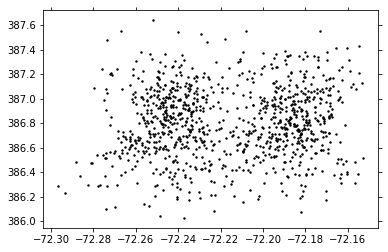

length of x list is  980 items


In [4]:
#verify with quicklook
d.Quicklook()

##### Create New Text File

In [5]:
#create new text file with first two columns of input file
#note, first column is in Data.X, second column is in Data.y
d.WriteTableData(filename='rays2.txt')

##### Show Mean and Standard Deviation

In [6]:
# mean and stddev of D.x
print(f'rays.txt, first column, mean: {d.x.mean():.3e}, '
        f'standard deviation: {d.x.std(ddof=1):.3e}')

rays.txt, first column, mean: -7.222e+01, standard deviation: 3.236e-02


##### Truncate to 25 Elements

In [8]:
from copy import deepcopy
# truncate data to first 25 elements
d2 = deepcopy(d) #preserve object d
slc = slice(None, 25)
d2.Slice(slc)

print(f'd2.nx: {d2.nx}, d2.ny: {d2.ny}, len(d2.x): {len(d2.x)}, len(d2.y): {len(d2.y)}')

d2.nx: 25, d2.ny: 25, len(d2.x): 25, len(d2.y): 25


##### Write out Truncated Data

In [9]:
# write out the truncated data
d2.WriteTableData('rays3.txt')

See the excel file `McManus_3.xlsx` for reading and plotting the data in `rays3.txt`.

##### Additional Data Visualization

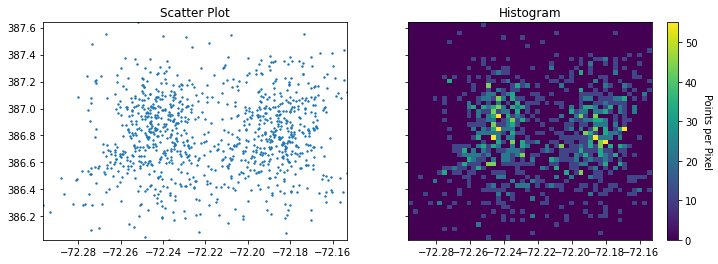

In [7]:
# Additional Data Visualization
fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharex=True, sharey=True)
ax[0].scatter(d.x, d.y, s=2); ax[0].set_title('Scatter Plot')
pcm = ax[1].hist2d(d.x, d.y, bins=50, density=True); ax[1].set_title('Histogram')
cbar = fig.colorbar(pcm[3], label='Points per Pixel')
cbar.set_label('Points per Pixel', rotation=270, va='bottom')

## `grades.xlsx`

##### Read the `grades.xlsx` Excel File

In [10]:
#create new object to hold the grade info
xlsx = MyData()

#read in the file
xlsx.ReadExcelColumn('grades.xlsx','Sheet1','Final Percentage')

##### Show Mean and Standard Deviation of Grades

In [11]:
#show mean and stddev
print(f'filename: {xlsx.filename}, the average is: {xlsx.x.mean():.1f}%, '
        f'and sigma is: {xlsx.x.std(ddof=1):.1f}%')

filename: grades.xlsx, the average is: 82.4%, and sigma is: 16.5%


##### Data Visualization of Grades

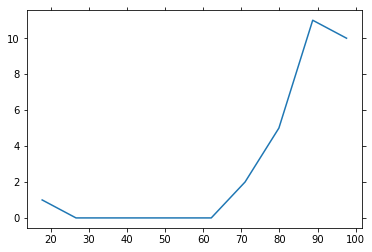

In [12]:
xlsx.MyHistogram()

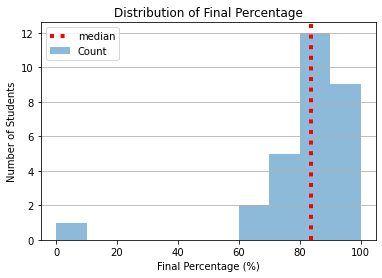

In [13]:
med = np.median(xlsx.x)
bins=np.arange(0,110,10)

fig, ax = plt.subplots()
zz=ax.hist(xlsx.x, bins=bins, alpha=0.5, label='Count')
ax.axvline(med, color='red', lw=4, ls=':', label='median')
ax.set_xlabel('Final Percentage (%)')
ax.set_ylabel('Number of Students')
ax.set_title('Distribution of Final Percentage')
ax.grid(axis='y')
ax.legend()